In [1]:
# -*- coding: utf-8 -*-

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 50 # pixels/μm

cell_size = mp.Vector3(14,14)

pml_layers = [mp.PML(thickness=2)]

# rotation angle (in degrees) of waveguide, counter clockwise (CCW) around z-axis
rot_angle = np.radians(20)

geometry = [mp.Block(center=mp.Vector3(),
                     size=mp.Vector3(mp.inf,1,mp.inf),
                     e1=mp.Vector3(1).rotate(mp.Vector3(z=1), rot_angle),
                     e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), rot_angle),
                     material=mp.Medium(epsilon=12))]

fsrc = 0.15 # frequency of eigenmode or constant-amplitude source
kx = 0.4    # initial guess for wavevector in x-direction of eigenmode
bnum = 1    # band number of eigenmode

compute_flux = False # compute flux (True) or plot the field profile (False)

eig_src = True # eigenmode (True) or constant-amplitude (False) source

if eig_src:
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fsrc,fwidth=0.2*fsrc) if compute_flux else mp.ContinuousSource(fsrc),
                                  center=mp.Vector3(),
                                  size=mp.Vector3(y=14),
                                  direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
                                  eig_kpoint=mp.Vector3(kx).rotate(mp.Vector3(z=1), rot_angle),
                                  eig_band=bnum,
                                  eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
                                  eig_match_freq=True)]
else:
    sources = [mp.Source(src=mp.GaussianSource(fsrc,fwidth=0.2*fsrc) if compute_flux else mp.ContinuousSource(fsrc),
                         center=mp.Vector3(),
                         size=mp.Vector3(y=2),
                         component=mp.Ez)]

sim = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    symmetries=[mp.Mirror(mp.Y)] if rot_angle == 0 else [])

-----------
Initializing structure...
Meep progress: 6.75/100.0 = 6.8% done in 4.0s, 55.3s to go
Meep progress: 13.83/100.0 = 13.8% done in 8.0s, 49.9s to go
Meep progress: 20.78/100.0 = 20.8% done in 12.0s, 45.8s to go
Meep progress: 27.830000000000002/100.0 = 27.8% done in 16.0s, 41.5s to go
Meep progress: 34.87/100.0 = 34.9% done in 20.0s, 37.4s to go
Meep progress: 41.86/100.0 = 41.9% done in 24.0s, 33.3s to go
Meep progress: 48.65/100.0 = 48.6% done in 28.0s, 29.6s to go
Meep progress: 55.52/100.0 = 55.5% done in 32.0s, 25.7s to go
Meep progress: 62.51/100.0 = 62.5% done in 36.0s, 21.6s to go
Meep progress: 69.52/100.0 = 69.5% done in 40.0s, 17.5s to go
Meep progress: 76.52/100.0 = 76.5% done in 44.0s, 13.5s to go
Meep progress: 83.45/100.0 = 83.5% done in 48.0s, 9.5s to go
Meep progress: 90.52/100.0 = 90.5% done in 52.0s, 5.4s to go
Meep progress: 97.52/100.0 = 97.5% done in 56.0s, 1.4s to go
run 0 finished at t = 100.0 (10000 timesteps)


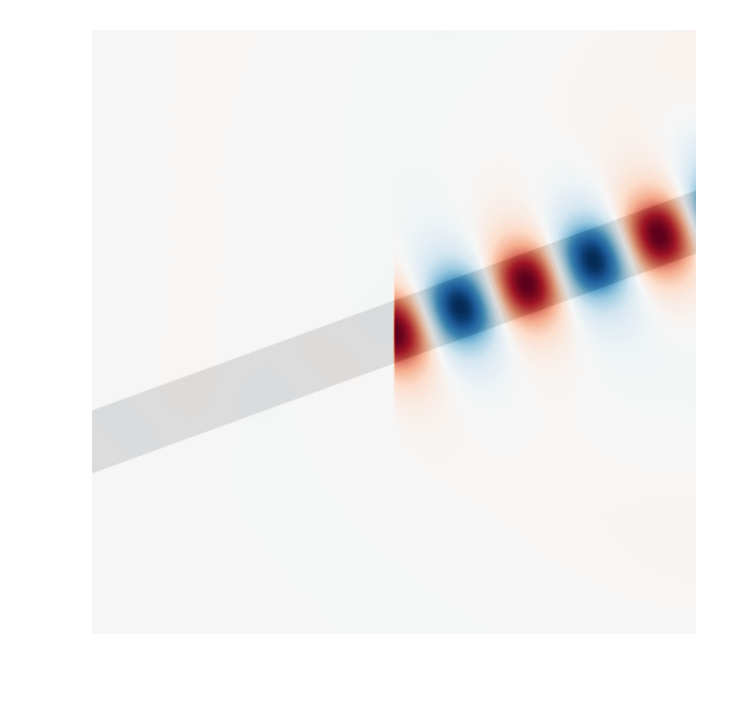

In [2]:
if compute_flux:
    tran = sim.add_flux(fsrc, 0, 1, mp.FluxRegion(center=mp.Vector3(x=5), size=mp.Vector3(y=14)))
    sim.run(until_after_sources=50)
    print("flux:, {:.6f}".format(mp.get_fluxes(tran)[0]))
else:
    sim.run(until=100)
    nonpml_vol = mp.Volume(center=mp.Vector3(), size=mp.Vector3(10,10,0))
    eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
    ez_data = sim.get_array(vol=nonpml_vol, component=mp.Ez)
    plt.figure(dpi=200)
    plt.imshow(np.flipud(np.transpose(eps_data)), interpolation='spline36', cmap='binary')
    plt.imshow(np.flipud(np.transpose(ez_data)), interpolation='spline36', cmap='RdBu', alpha=0.9)
    plt.axis('off')